In [3]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import scipy.optimize as opt

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [21]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
acs_data = acs_data.sample(500, random_state=0)

# 1.2 Proxies

In [32]:
from sklearn.model_selection import train_test_split
data = ACSIncomeNew.df_to_pandas(acs_data)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data[0], data[1], data[2], test_size=0.2, random_state=0)

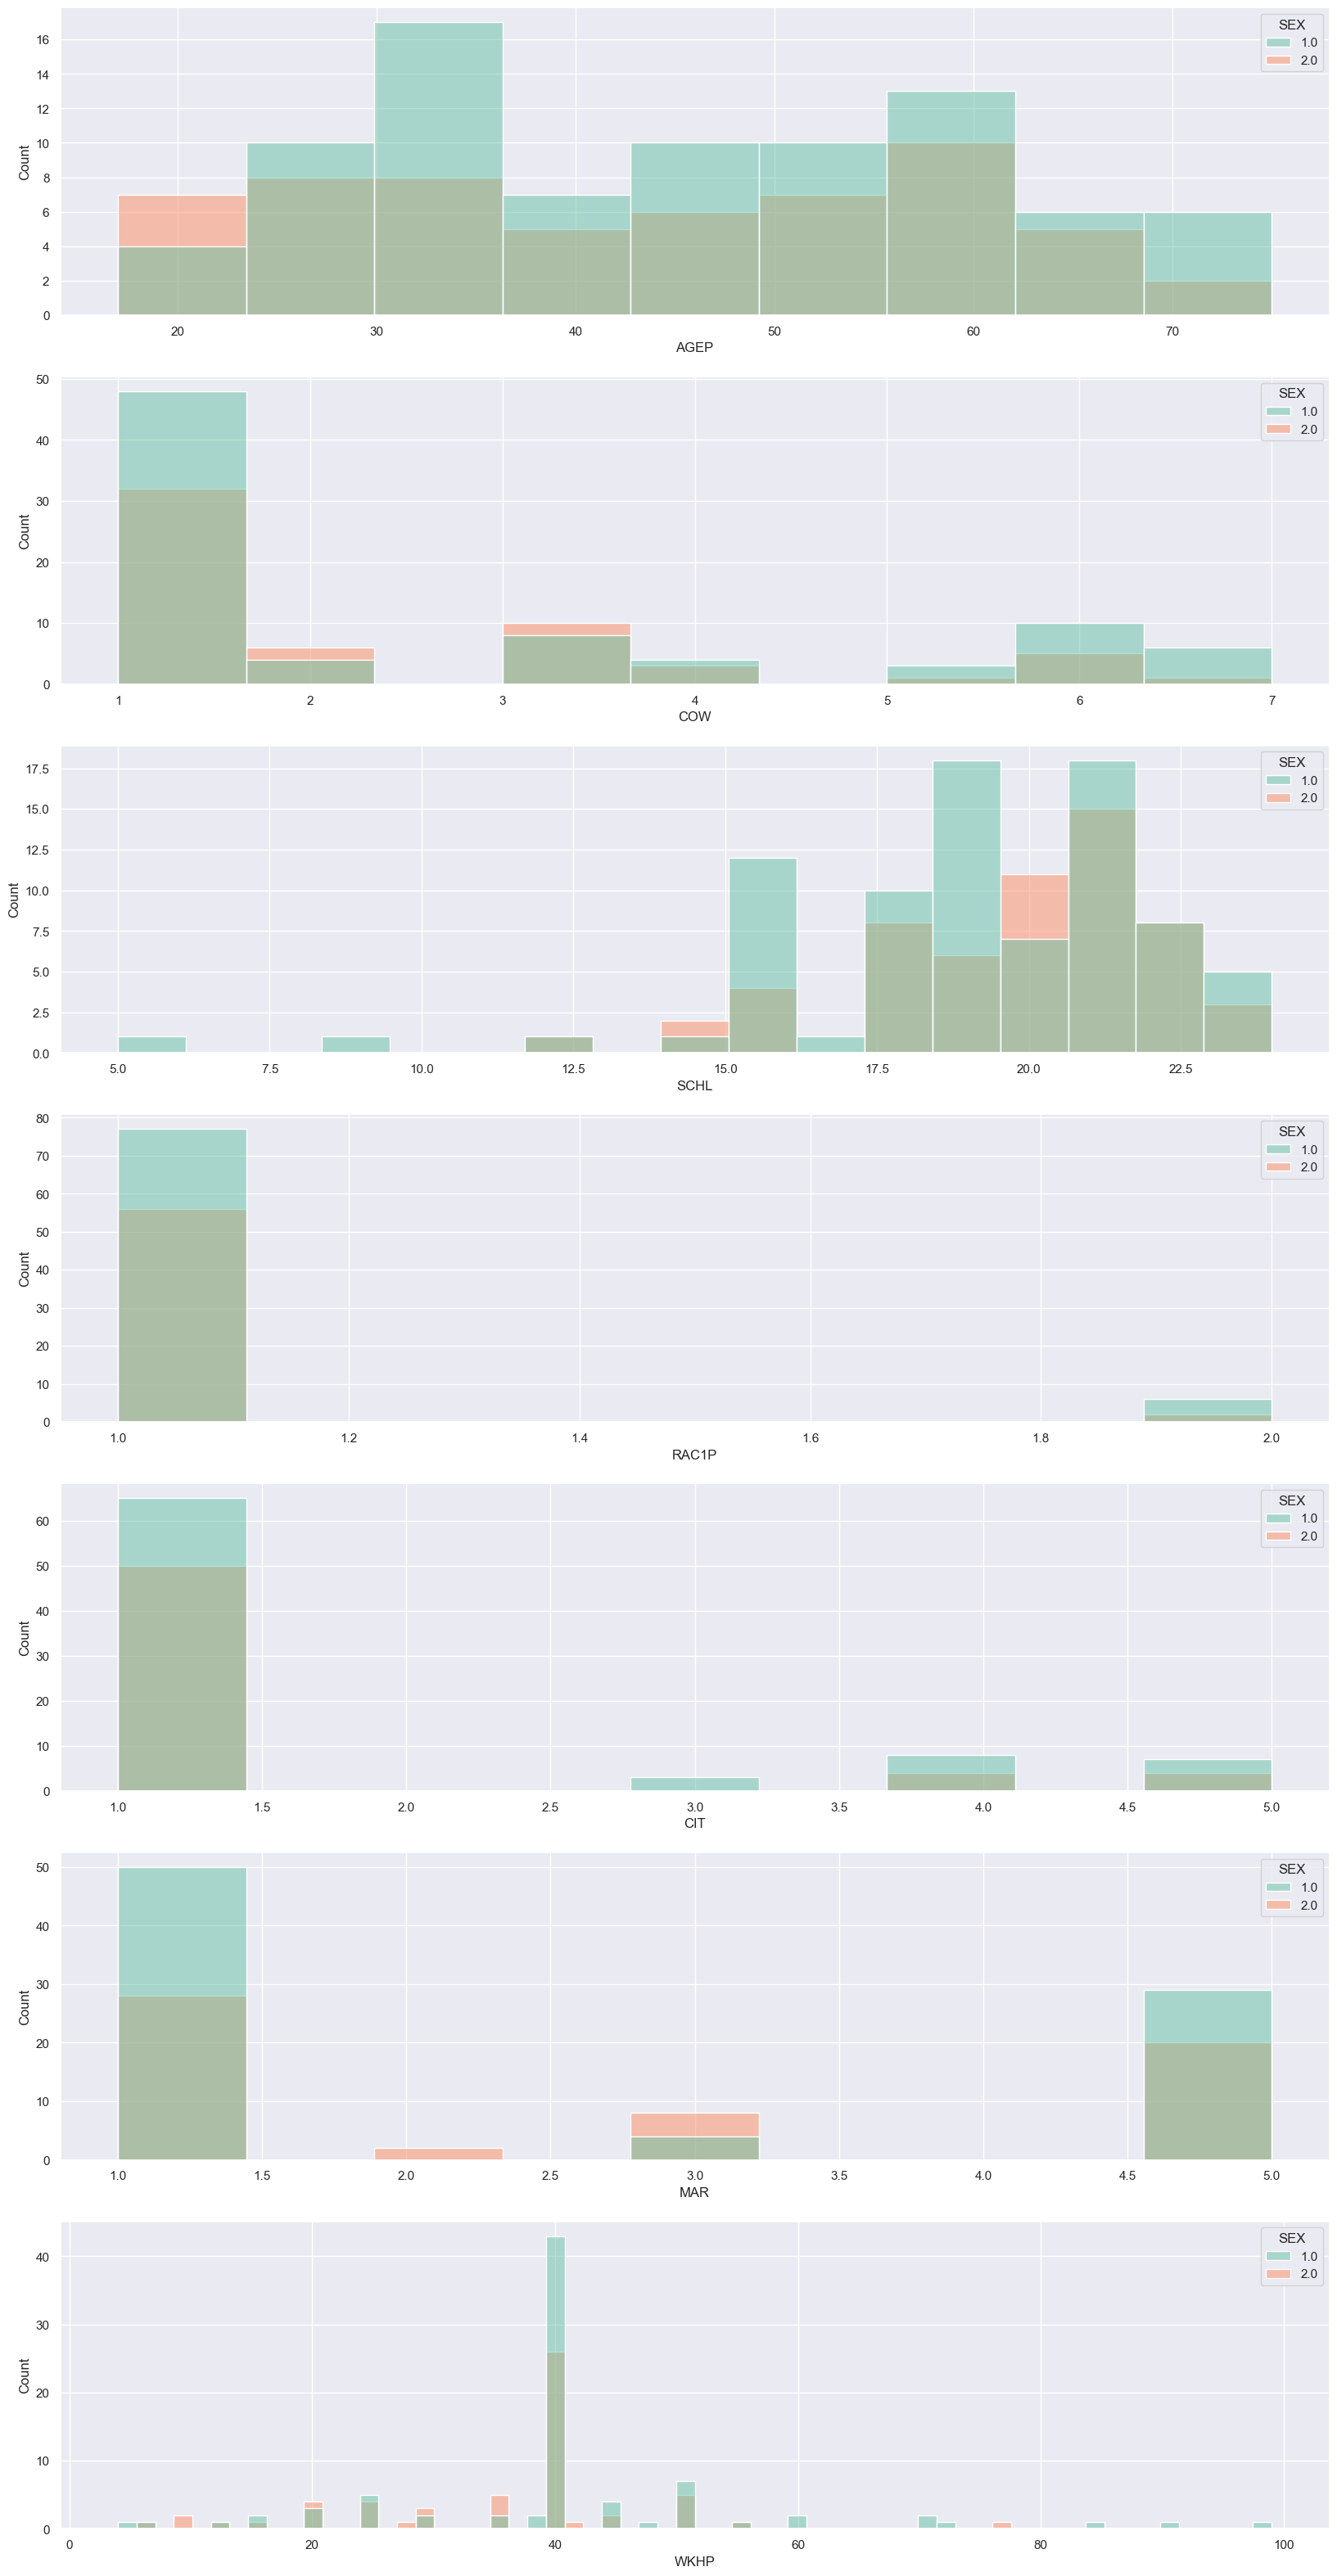

In [105]:
males = X_train[X_train['SEX'] == 1]
females = X_train[X_train['SEX'] == 2]

import matplotlib.pyplot as plt
import seaborn as sns
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(7, figsize=(20, 40))
for i, feature in enumerate(['AGEP', 'COW', 'SCHL', 'RAC1P', 'CIT', 'MAR','WKHP']):
    sns.histplot(data=X_train, x=feature, hue='SEX', ax=axes[i], palette='Set2')
plt.show()

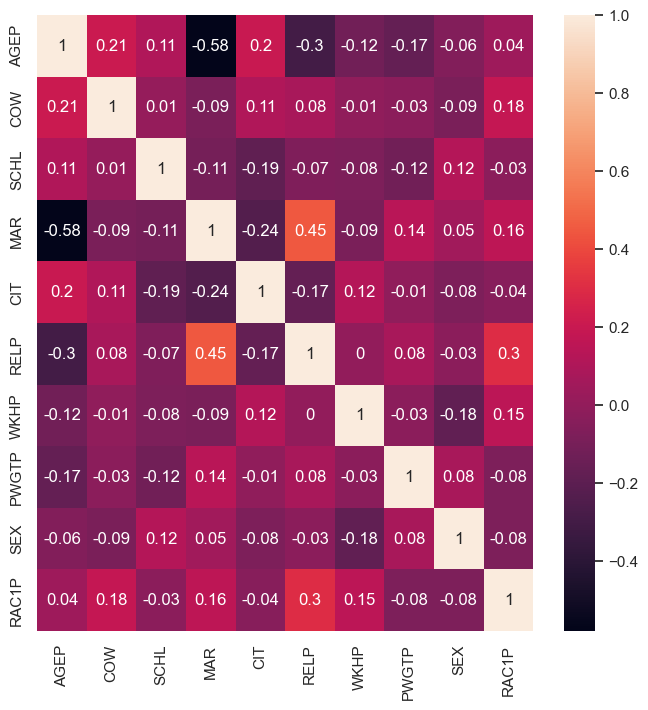

In [137]:
corr = X_train.corr()
sns.set(font_scale=1)
sns.heatmap(corr.round(2), annot=True)
sns.set_style('whitegrid', {'axes.grid' : False})
plt.show()

In [ ]:

corr = X_train.corr()
# remove 0s in front of decimal values in plot

corr = corr.round(2)
sns.set(font_scale=1)
sns.heatmap(corr.round(2), annot=True)

# 2.1 Data

In [ ]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                          "RAC1P_White alone" ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

In [ ]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 500 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [ ]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P
features.head()

In [ ]:
# look at feature distributions
acs_data = ACSIncomeNew.get_data(data_source)
acs_data.hist(figsize=(20, 20), bins=50)
